Construct an emulator for $P(k)$ where we only consider one of the HOD parameters --- $\alpha$! 

In [1]:
import numpy as np 
import george as George
import scipy.optimize as op
# -- local -- 
import env
import lhd as LHD
import data as Data
import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

1-dimensional Latin Hypercube Design

In [3]:
# 1D Latin Hypercube Design
lhd_1d = LHD.LHD(1, samples=40, method='mdu')
print lhd_1d.flatten()

[ 0.36605079  0.4521035   0.15404072  0.29746385  0.44016073  0.92522993
  0.12753679  0.11658754  0.65012654  0.8040202   0.26371834  0.76729738
  0.19129903  0.38060673  0.71780448  0.30593123  0.50813499  0.59366229
  0.06624082  0.79623059  0.49144032  0.86420772  0.40234187  0.9091929
  0.03163006  0.83109974  0.97432526  0.20982744  0.69730116  0.01577847
  0.54487028  0.08756593  0.6144226   0.88731294  0.62988107  0.9930613
  0.23201931  0.5506079   0.74113681  0.32942777]


HOD parameters where $log M_\mathrm{min}, \sigma_{\log M}, \log\,M_0$, and $\log M_1$ are fiducial values and $\alpha$ is selected by the LHD

In [19]:
thetas = np.zeros((len(lhd_1d), 5))
thetas[:,0] = 11.60 # log M_min
thetas[:,1] = 0.26  # sigma_logM
thetas[:,2] = 11.49 # log M0
thetas[:,3] = 12.83 # log M1
thetas[:,4] = 0.5 + np.array(lhd_1d.flatten()) # alpha sampled by LHD 

In [20]:
print thetas[:,4]

[ 0.86605079  0.9521035   0.65404072  0.79746385  0.94016073  1.42522993
  0.62753679  0.61658754  1.15012654  1.3040202   0.76371834  1.26729738
  0.69129903  0.88060673  1.21780448  0.80593123  1.00813499  1.09366229
  0.56624082  1.29623059  0.99144032  1.36420772  0.90234187  1.4091929
  0.53163006  1.33109974  1.47432526  0.70982744  1.19730116  0.51577847
  1.04487028  0.58756593  1.1144226   1.38731294  1.12988107  1.4930613
  0.73201931  1.0506079   1.24113681  0.82942777]


Before we begin with $P_0(k)$ emulation, lets start with a completely toy example of emulating some simple function $f(\alpha)$

(0.5, 1.5)

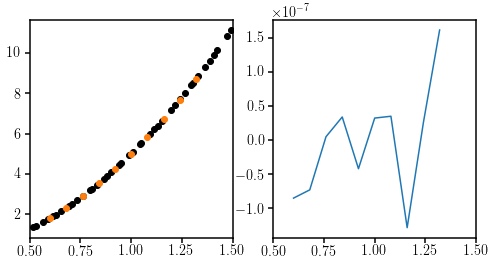

In [6]:
def somefunc(x): 
    return 5.*x**2

# first build a training set
x_train = thetas[:,4]
y_train = somefunc(x_train)

# testing set
x_test = [0.6 + 0.08 * i for i in range(10)]

# train GP 
lguess =  (np.max(x_train) - np.min(x_train))/float(len(x_train))
kernel = np.var(y_train) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
gp_toy = George.GP(kernel, mean=np.average(y_train))
gp_toy.compute(x_train)

# GP predictions
y_test = []
for xx in x_test: 
    fx,_ = gp_toy.predict(y_train, xx)#emu(alph, gp_emu, f(thetas[:,4]))
    y_test.append(fx)

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub.scatter(x_train, y_train, c='k')#thetas[:,4], f(thetas[:,4]))
sub.scatter(x_test, y_test, c='C1')
sub.set_xlim([0.5, 1.5])
sub = fig.add_subplot(122)
sub.plot(x_test, np.array(y_test).flatten() - [somefunc(xx) for xx in x_test])
sub.set_xlim([0.5, 1.5])

[ 5.40927501  2.14243517 -3.71185863]
278.393140671
[ 5.40927501  2.14243517 -3.71185863]
278.393140671


/Users/chang/anaconda2/lib/python2.7/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


(0.5, 1.5)

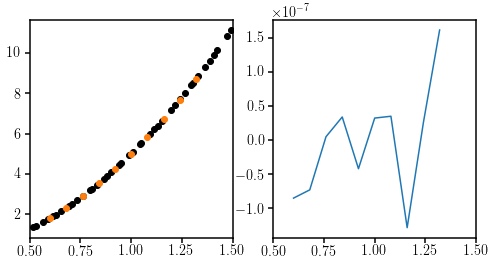

In [7]:
def somefunc(x): 
    return 5.*x**2

# first build a training set
x_train = thetas[:,4]
y_train = somefunc(x_train)

# testing set
x_test = [0.6 + 0.08 * i for i in range(10)]

# train GP 
lguess =  (np.max(x_train) - np.min(x_train))/float(len(x_train))
kernel = np.var(y_train) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
gp_toy = George.GP(kernel, mean=np.mean(y_train), fit_mean=True)
gp_toy.compute(x_train)
# optimize
p0 = gp_toy.get_parameter_vector()
print p0
print(gp_toy.log_likelihood(y_train))
results = op.minimize(gp_toy.nll, p0, args=(y_train), jac=gp_toy.grad_nll)#, method='L-BFGS-B')
gp_toy.set_parameter_vector(results.x)
print results.x
print(gp_toy.log_likelihood(y_train))

# GP predictions
y_test = []
for xx in x_test: 
    fx,_ = gp_toy.predict(y_train, xx)#emu(alph, gp_emu, f(thetas[:,4]))
    y_test.append(fx)

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub.scatter(x_train, y_train, c='k')#thetas[:,4], f(thetas[:,4]))
sub.scatter(x_test, y_test, c='C1')
sub.set_xlim([0.5, 1.5])
sub = fig.add_subplot(122)
sub.plot(x_test, np.array(y_test).flatten() - [somefunc(xx) for xx in x_test])
sub.set_xlim([0.5, 1.5])

Since the toy example worked pretty damn well, now lets generate $P_0(k)$ for these $\theta$s by first forward modeling the galaxy catalog $F(\theta)$ and measuring $P_0(k)$ from it

In [8]:
# halo catalog 
halos = Data.NeutHalos(0.0, 1, 4)

In [9]:
def BigF(theta, halos): 
    # F(theta) --- i.e. the galaxy catalog generated
    # from the halo catalog
    p_hod = {'logMmin': theta[0], 'sigma_logM': theta[1], 'logM0': theta[2], 'logM1': theta[3], 'alpha': theta[4]}
    g = FM.Galaxies(halos, p_hod, seed=seed)
    g['RSDPosition'] = FM.RSD(g, LOS=[0,0,1]) # impose RSD
    return g

def ObvsBigF(bigf, obvs='p0k'):
    # measure P(k) from F(theta)
    plk = FM.Observables(bigf, observable='plk', rsd=True, Nmesh=180)
    if obvs == 'p0k': 
        return plk['k'], plk['p0k']

$P_0(k)$ training set generated from Latin Hypercube Design of $\theta$ (in our case just $\alpha$)

In [10]:
seed = 1
p0k_lhd = []
for i in range(thetas.shape[0]): 
    gals_i = BigF(thetas[i,:], halos)
    kk, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_lhd.append(p0k_i)
    if i == 0: karr = kk
p0k_lhd = np.array(p0k_lhd)

$P_0(k)$ testing set

In [21]:
p0k_test = []
for i in range(10): 
    tt = thetas[0,:].copy()
    tt[4] = 0.6+0.08*i
    gals_i = BigF(tt, halos)
    _, p0k_i = ObvsBigF(gals_i, obvs='p0k')
    p0k_test.append(p0k_i)
    if i == 0: karr = kk
p0k_test = np.array(p0k_test)

Lets see what the $P_0(k)$s look like sorted in ascending order of $\alpha$

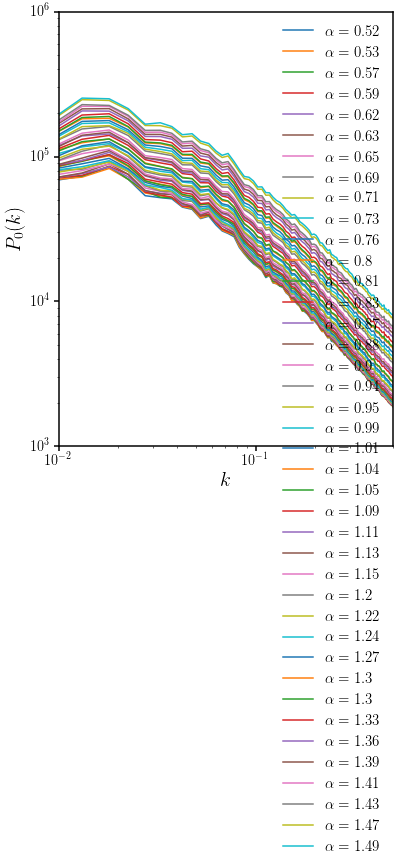

In [22]:
isort = np.argsort(lhd_1d.flatten())

fig = plt.figure(figsize=(6, 8))
sub = fig.add_subplot(111)
for i in isort:
    sub.plot(karr, p0k_lhd[i,:], label=r"$\alpha = "+str(round(thetas[i,4],2))+"$")
sub.legend(loc='upper right', prop={'size': 15}) 
# x-axis
sub.set_xscale('log')
sub.set_xlim([0.01, 0.5])
sub.set_xlabel('$k$', fontsize=20)
# y-axis
sub.set_yscale('log')
sub.set_ylim([1e3, 1e6])
sub.set_ylabel('$P_0(k)$', fontsize=20)

[ 0.51577847  0.53163006  0.56624082  0.58756593  0.61658754  0.62753679
  0.65404072  0.69129903  0.70982744  0.73201931  0.76371834  0.79746385
  0.80593123  0.82942777  0.86605079  0.88060673  0.90234187  0.94016073
  0.9521035   0.99144032  1.00813499  1.04487028  1.0506079   1.09366229
  1.1144226   1.12988107  1.15012654  1.19730116  1.21780448  1.24113681
  1.26729738  1.29623059  1.3040202   1.33109974  1.36420772  1.38731294
  1.4091929   1.42522993  1.47432526  1.4930613 ]


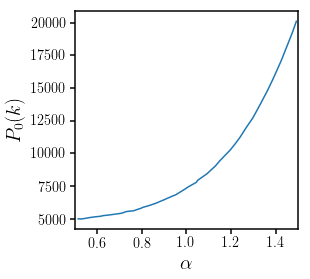

In [23]:
isort = np.argsort(thetas[:,4])

fig = plt.figure(figsize=(4,4))
sub = fig.add_subplot(111)
print thetas[isort,4]
sub.plot([thetas[i,4] for i in isort], [p0k_lhd[i,50] for i in isort])
# x-axis
sub.set_xlim([0.5, 1.5])
sub.set_xlabel(r'$\alpha$', fontsize=20)
# y-axis
sub.set_ylabel('$P_0(k)$', fontsize=20)

Pretty straightforward monotonic relations with $\alpha$, lets see how well we can emulate one $k$ bin of $P_0$ with a GP emulator

(-0.05, 0.05)

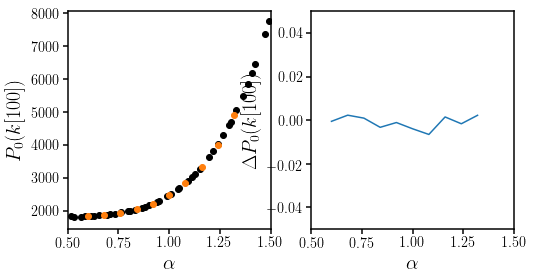

In [24]:
i_k = 100
# first build a training set
x_train = thetas[:,4]
mu_p0k = np.mean(p0k_lhd[:,i_k])
sig_p0k = np.std(p0k_lhd[:,i_k])
y_train = (p0k_lhd[:,i_k] - mu_p0k)/sig_p0k

# testing set
x_test = [0.6 + 0.08 * i for i in range(10)]
 
# train GP 
lguess =  (np.max(x_train) - np.min(x_train))/float(len(x_train))
kernel = np.var(y_train) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
gp_toy = George.GP(kernel, mean=np.mean(y_train), fit_mean=True)
gp_toy.compute(x_train)

# GP predictions
y_test,_ = gp_toy.predict(y_train, x_test)#emu(alph, gp_emu, f(thetas[:,4]))

fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(121)
sub.scatter(x_train, y_train * sig_p0k + mu_p0k, c='k')#thetas[:,4], f(thetas[:,4]))
sub.scatter(x_test, y_test * sig_p0k + mu_p0k, c='C1')
sub.set_xlim([0.5, 1.5])
sub.set_xlabel(r'$\alpha$', fontsize=20)
sub.set_ylabel(r'$P_0(k['+str(i_k)+'])$', fontsize=20)
sub = fig.add_subplot(122)
sub.plot(x_test, ((y_test * sig_p0k + mu_p0k) - p0k_test[:,i_k])/p0k_test[:,i_k])#[somefunc(xx) for xx in x_test])
sub.set_xlim([0.5, 1.5])
sub.set_xlabel(r'$\alpha$', fontsize=20)
sub.set_ylabel(r'$\Delta P_0(k['+str(i_k)+'])$', fontsize=20)
sub.set_ylim([-0.05, 0.05])

In [25]:
def trainGP(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    # note X is 1 dimensional
    lguess =  (np.max(X) - np.min(X))/float(len(X))

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True, fit_white_noise=True)
        gp.compute(X)
        gps.append(gp)
    return gps

In [26]:
def trainGP_opt(X, Y): 
    # train GP for each dimension of Y -- i.e. treat each k value of P_0 as a separate component
    # note X is 1 dimensional
    lguess =  (np.max(X) - np.min(X))/float(len(X))

    gps = [] 
    for i in range(Y.shape[1]): 
        kernel = np.var(Y[:,i]) * George.kernels.ExpSquaredKernel(lguess)#, ndim=Y.shape[1])
        gp = George.GP(kernel, mean=np.mean(Y[:,i]), fit_mean=True)
        gp.compute(X)
        # optimize hyperparameters
        p0 = gp.get_parameter_vector()
        results = op.minimize(gp.nll, p0, args=(Y[:,i]), jac=gp.grad_nll, method='L-BFGS-B')
        gp.set_parameter_vector(results.x)
        gps.append(gp)
    return gps

In [27]:
def emu(x_pred, gps, Y): 
    # use GPs to predict Plk at x_pred
    mus, vs = np.zeros(len(gps)), np.zeros(len(gps))
    for i, gp in enumerate(gps): 
        mu, var = gp.predict(Y[:,i], x_pred)
        mus[i] = mu
        vs[i] = var
    return mus, vs

Lets compare the residual between $P_0^{GP}(k|\theta)$ versus $P_0(k|\theta)$

(-0.05, 0.05)

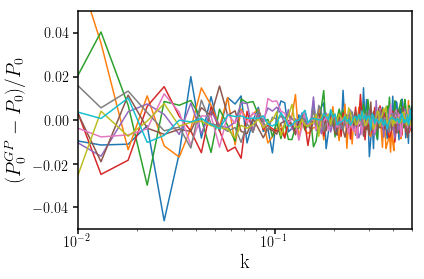

In [29]:
# "whiten" the P_0 training data
mu_p0k_train = np.sum(p0k_lhd[1:,:], axis=0)/float(p0k_lhd.shape[0])
sig_p0k_train = np.std(p0k_lhd[1:,:], axis=0)
Y_train = (p0k_lhd[1:,:] - mu_p0k_train)/sig_p0k_train
gp_emu = trainGP(thetas[1:,4], Y_train)

Y_test = []
for i in range(10): 
    Y_gp,_ = emu(0.6 + 0.08 * i, gp_emu, Y_train)
    Y_test.append(Y_gp)
Y_test = np.array(Y_test)
    
fig = plt.figure()
sub = fig.add_subplot(111)    
for i_y, yt in enumerate(Y_test): 
    sub.plot(karr, (yt * sig_p0k_train + mu_p0k_train - p0k_test[i_y,:])/p0k_test[i_y,:])
sub.set_xlabel('k', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)
sub.set_ylim([-0.05, 0.05])

(-0.05, 0.05)

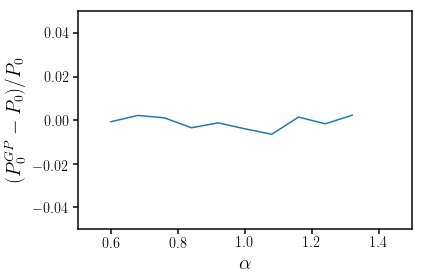

In [30]:
fig = plt.figure()
sub = fig.add_subplot(111)    
sub.plot(x_test, (Y_test[:,i_k] * sig_p0k_train[i_k] + mu_p0k_train[i_k] - p0k_test[:,i_k])/p0k_test[:,i_k])
sub.set_xlabel(r'$\alpha$', fontsize=20)
sub.set_xlim([0.5, 1.5])
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)
sub.set_ylim([-0.05, 0.05])

(-0.05, 0.05)

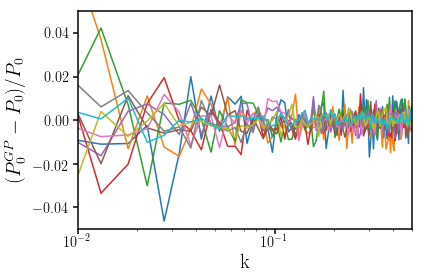

In [31]:
mu_p0k_train = np.sum(p0k_lhd, axis=0)/float(p0k_lhd.shape[0])
sig_p0k_train = np.std(p0k_lhd, axis=0)
Y_train = (p0k_lhd - mu_p0k_train)/sig_p0k_train
gp_emu_opt = trainGP_opt(thetas[:,4], Y_train)

Y_test = []
for i in range(10): 
    Y_gp,_ = emu(0.6 + 0.08 * i, gp_emu_opt, Y_train)
    Y_test.append(Y_gp)
Y_test = np.array(Y_test)
    
fig = plt.figure()
sub = fig.add_subplot(111)    
for i_y, yt in enumerate(Y_test): 
    sub.plot(karr, (yt * sig_p0k_train + mu_p0k_train - p0k_test[i_y,:])/p0k_test[i_y,:])
sub.set_xlabel('k', fontsize=20)
sub.set_xlim([0.01, 0.5])
sub.set_xscale('log')
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)
sub.set_ylim([-0.05, 0.05])

(-0.05, 0.05)

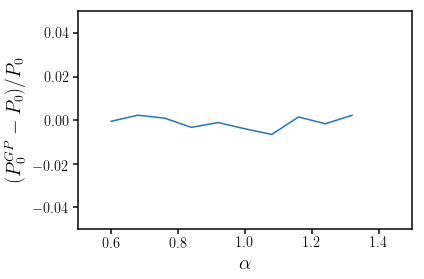

In [32]:
fig = plt.figure()
sub = fig.add_subplot(111)    
sub.plot(x_test, (Y_test[:,i_k] * sig_p0k_train[i_k] + mu_p0k_train[i_k] - p0k_test[:,i_k])/p0k_test[:,i_k])
sub.set_xlabel(r'$\alpha$', fontsize=20)
sub.set_xlim([0.5, 1.5])
sub.set_ylabel('$(P_0^{GP} - P_0)/P_0$', fontsize=20)
sub.set_ylim([-0.05, 0.05])